<a href="https://colab.research.google.com/github/anna985/pml-1/blob/master/course/Problem025_NNScratch/025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TBD Code reading, Below is a from-scratch  3 layer neural network. Main training code is in the *fit* method 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.datasets import mnist
from keras.utils import np_utils
%matplotlib inline

plt.rcParams['figure.figsize'] = (5.0, 4.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
def relu(Z):
    """
    Rectified Linear Unit (relu Function) x if x > 0 else x

    :param Z: input tensor
    :return:  Relu output
    """
    A = np.maximum(0, Z)
    return A

def sigmoid(Z):
    """
    Sigmoid Function
    :param Z: input tensor
    :return: Sigmoid output
    """
    A = 1 / (1 + np.exp(-Z))
    return A


def relu_backward(dA, Z):
    """
    Derivative of relu function

    :param dA:  How cost changes with activation ( dJ_by_dA )
    :param Z:
 
    :return:  How cost changes with weighted sum (Z) ( dJ_by_dZ )
    """

    dZ = np.array(dA, copy=True) 

    dZ[Z <= 0] = 0

    return dZ


def sigmoid_backward(dA, Z):
    """
    Derivative of sigmoid function

    :param dA: How cost changes with activation ( dJ_by_dA )
    :param Z:
    
    :return: How cost changes with weighted sum (Z) ( dJ_by_dZ )
    """

    s = 1 / (1 + np.exp(-Z))
    dZ = dA * s * (1 - s)

    return dZ



In [3]:
def init_weights(n_x, n_h1, n_h2, n_y):
    """

    Initialize weights tensor

    :param n_x: size of the input layer
    :param n_h1: size of the hidden layer 1
    :param n_h2: size of the hidden layer 2
    :param n_y: size of the output layer

    :return:     weights -- python dictionary containing initialized weights:
                    W1 -- weight matrix of shape (n_h1, n_x)
                    b1 -- bias vector of shape (n_h1, 1)
                    W2 -- weight matrix of shape (n_h2, n_h1)
                    b2 -- bias vector of shape (n_h2, 1)
                    W3 -- weight matrix of shape (n_y, n_h2)
                    b3 -- bias vector of shape (n_y, 1)
    """

    np.random.seed(1)

    W1 = np.random.randn(n_h1, n_x) * 0.01
    b1 = np.zeros((n_h1, 1))
    W2 = np.random.randn(n_h2, n_h1) * 0.01
    b2 = np.zeros((n_h2, 1))
    W3 = np.random.randn(n_y, n_h2) * 0.01
    b3 = np.zeros((n_y, 1))

    weights = { "W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3": W3, "b3": b3 }

    return weights


In [4]:
def step_forward(A, W, b, activation_function):
    """
    Step forward one layer in a deep neural network

    :param A: Input tensor for the layer
    :param W: Weight tensor for the layer
    :param b: Bias tensor for the layer
    :param activation_function: Activation function to be applied to the layer

    :return: Output Activation tensor and Weighted sum
    """

    Z = np.matmul(W, A) + b
    A_next = activation_function(Z)

    return A_next, Z


def compute_cost(AL, Y):
    """

    Cross Entropy Error (Cost) between Y-Hat and Y  (Y-Hat is activation of Lth Layer hence AL)

    :param AL: Activation of Lth Layer i.e Y-Hat
    :param Y: Actual Labels (Ground Truth)

    :return: Cost (How close are we?)

    """
    
    m = Y.shape[1]
    cost = -(np.sum(Y * np.log(AL) + (1 - Y) * np.log(1 - AL))) / m
    cost = np.squeeze(cost)

    return cost


def step_backward(dA, Z, A_prev, W, b, activation_function_backward):
    """
    Step back one layer in deep neural network,
    i.e Find out how much adjustment is needed in weights in this layer

    :param dA: How Final cost changes with Activation of this layer ( dJ_by_dA )
    :param Z: Weighted Sum from this layer
    :param A_prev: Incoming activations to this layer
    :param W: Weights of this layer
    :param b: Bias of this layer
    :param activation_function_backward:
    
    :return:
        dA_prev : How cost changes with activation from prev layer ( dJ_by_dA_prev), need this for further back propagation of cost to previous layer
        dW: How cost changes with weights of this layer (our prize). (dJ_by_dW)
        db: How cost changes with weights of this layer (dJ_by_db)
    """

    dZ = activation_function_backward(dA, Z)

    N = A_prev.shape[1]

    dW = np.matmul(dZ, A_prev.transpose()) / N
    db = np.sum(dZ, axis=1, keepdims=True) / N
    dA_prev = np.matmul(W.transpose(), dZ)

    return dA_prev, dW, db


def update_weights(weights, grads, learning_rate):
    """
    Update weights across all layers
    After our back-propogation we know how much weight & bias adjustment is needed
    in each layer, This function performs that update.

    :param weights: Original weights
    :param grads: Changes that needs to be made to weights (dW and db s)
    :param learning_rate: learning rate of algorithm. (a step length in gradient descent)

    :return: updated weights
    """
    L = len(weights)//2    # number of layers in the neural network

    for l in range(L):
        weights["W" + str(l + 1)] = weights["W" + str(l + 1)] - learning_rate * grads["dW" + str(l + 1)]
        weights["b" + str(l + 1)] = weights["b" + str(l + 1)] - learning_rate * grads["db" + str(l + 1)]

    return weights


## Fit (Training of Neural network using back propagation and gradient descent )
<img src="https://github.com/rawata/pml/blob/master/img/nn_training_loop.png?raw=1" alt="drawing" width="400"/>




In [5]:


def fit(X, Y, layers_dims, learning_rate=0.0075, num_iterations=10000, print_cost=False):
    """
    Trains a 3 layer neural network

    :param X: input features
    :param Y: output labels
    :param layers_dims: number of nodes in each layer ( inputs, number of neurons in each hidden layer, output)
    :param learning_rate: 
    :param num_iterations:
    :param print_cost: 

    :return: Weights and Bias of the trained network. 

    """
    np.random.seed(1)
    grads = {}
    costs = []  # to keep track of the cost
    m = X.shape[1]  # number of examples
    
    (n_x, n_h1, n_h2, n_y) = layers_dims

    weights = init_weights(n_x, n_h1, n_h2, n_y)

    for i in range(0, num_iterations):

        # Forward propagation: (LINEAR -> RELU) * 2 -> LINEAR -> SIGMOID.

        # Retrieve W1, b1, W2, b2 from weights
        W1 = weights["W1"]
        b1 = weights["b1"]
        W2 = weights["W2"]
        b2 = weights["b2"]
        W3 = weights["W3"]
        b3 = weights["b3"]


        A1, Z1  = step_forward(X, W1, b1, relu)
        A2, Z2  = step_forward(A1, W2, b2, relu)
        A3, Z3  = step_forward(A2, W3, b3, sigmoid)

        cost = compute_cost(A3, Y)

        # Initializing backward propagation
        dA3 = - (np.divide(Y, A3) - np.divide(1 - Y, 1 - A3))

        # gradient descent through back propagation
        dA2, dW3, db3 = step_backward(dA3, Z3, A2, W3, b3, sigmoid_backward)
        dA1, dW2, db2 = step_backward(dA2, Z2, A1, W2, b2, relu_backward)
        dA0, dW1, db1 = step_backward(dA1, Z1, X, W1, b1,  relu_backward)

        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        grads['dW3'] = dW3
        grads['db3'] = db3

        # Update weights.
        weights = update_weights(weights, grads, learning_rate)

        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)

    # plot the cost

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    return weights


## Predict and Accuracy

In [6]:
def predict(X, weights):
    """
    Given weights of deep neural network, predict the output for X

    :param X: input tensor
    :param weights: Weights and Bias of the network
    :return:
    """
    W1 = weights["W1"]
    b1 = weights["b1"]
    W2 = weights["W2"]
    b2 = weights["b2"]
    W3 = weights["W3"]
    b3 = weights["b3"]

    A1, Z1 = step_forward(X, W1, b1, relu)
    A2, Z2 = step_forward(A1, W2, b2, relu)
    A3, Z3 = step_forward(A2, W3, b3, sigmoid)
    A3 = np.around(A3)
    return A3


def compute_accuracy(X, Y, weights):
    """
    Compute predictions for X given the weights and then find out how accurate are the predictions
    by comparing with y

    :param X: Input Tensors to be predicted
    :param Y: Ground Truth Labels
    :param weights: Weight (Model)
    :return:
    """

    N = X.shape[1]
    A3 = predict(X, weights)
    res = A3 == Y
    accuracy = np.sum(res.all(axis=0)) / N
    print("Accuracy: " + str(accuracy))
    return accuracy


## Train on sklearn MNIST data 
input = 8X8 pixels


Cost after iteration 0: 6.927758213084503
Cost after iteration 100: 3.2734321092361194
Cost after iteration 200: 3.272013882242851
Cost after iteration 300: 3.27077045635114
Cost after iteration 400: 3.2694525244001924
Cost after iteration 500: 3.267752714442069
Cost after iteration 600: 3.2650325127930517
Cost after iteration 700: 3.25941325638326
Cost after iteration 800: 3.2429323993325827
Cost after iteration 900: 3.162153346617937
Cost after iteration 1000: 2.7514846262985024
Cost after iteration 1100: 2.2730131266448064
Cost after iteration 1200: 1.9297770181872405
Cost after iteration 1300: 1.5725724533918406
Cost after iteration 1400: 1.3669183679538262
Cost after iteration 1500: 1.2266482390271327
Cost after iteration 1600: 1.1015916303678444
Cost after iteration 1700: 0.9847125396257518
Cost after iteration 1800: 0.8746599979896628
Cost after iteration 1900: 0.7741030663294607
Cost after iteration 2000: 0.6834265317759509
Cost after iteration 2100: 0.6021422148264031
Cost aft

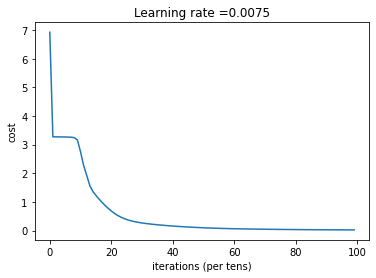

In [7]:
# Preparing the digits dataset
digits = datasets.load_digits()


X = digits.data

# One hot encoding of target (Y)
Y = np_utils.to_categorical(digits.target, 10)

# Train test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

# Transposing the input/output data as implementation expects them to be
# In Library implementations its usually the weights which are transposed

X_train = np.transpose(X_train)
X_test = np.transpose(X_test)
Y_train = np.transpose(Y_train)
Y_test = np.transpose(Y_test)


n_x = 64
n_h1 = 40
n_h2 = 20
n_y = 10
layers_dims = (n_x, n_h1, n_h2, n_y)

weights = fit(X_train, Y_train, layers_dims = (n_x, n_h1, n_h2, n_y), num_iterations = 10000, print_cost=True)



## Predict and compute accuracy

In [9]:
accuracy_train = compute_accuracy(X_train, Y_train, weights)
accuracy_test = compute_accuracy(X_test, Y_test, weights)


Accuracy: 0.9992576095025983
Accuracy: 0.9511111111111111


## TBD: Show some images for which the model makes errors


len of data = 1797
1797
dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])


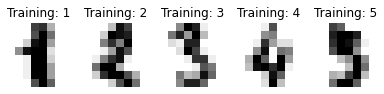

In [10]:
images_and_labels = list(zip(digits.images, digits.target))
print(f'len of data = {len(digits.data)}')
print(len(images_and_labels))
plt.figure(figsize=(8,6))
for index, (image, label) in enumerate(images_and_labels[1:6]):
    plt.subplot(1, 6, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % label)

print(digits.keys())

In [15]:
# print(digits['DESCR'])
print(len(digits['data'][0]))
# 64
print(len(digits['data']))
# 1797
print(digits['data'][0])

64
1797
[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]


In [16]:
# X_test[:,[1]]
ax_test = X_test[:, [19, 55, 300]]
ay_test = Y_test[:, [19, 55, 300]]
print(ay_test)

predict(ax_test, weights)

[[0. 1. 0.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]]


array([[0., 1., 0.],
       [0., 0., 0.],
       [0., 0., 1.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [1., 0., 0.],
       [0., 0., 0.]])

## TBD: Generalize the Fit function to accept any number of layers.
Currently fit is hardcoded for a 3 Layer neural network, with Relu Activation for L1 and L2 and Sigmoid activation for L3. Generalize the fit  to accept any layer and activation functions. You can use following sequence of steps to achieve this.

### TBD 1.  Change layer_dims to layer_confs, previously it was just a list of numbers but now it will be a list of tuples (number_of_nodes, activation_function). E.g layer_confs for existing NN will be. \[ (64, None), (40, relu), (20, relu), (10, sigmoid) \] 

### TBD 2.  Modify init_weights function to initilaize a general weights setting using layer_confs

### TBD 3.  Modify fit function to use layer_confs to loop to go forward and backward.

### TBD 4.  Use this general function to test the existing 3 layer configuration and see if you get same accuracy results


In [22]:
layer_confs = [ (64, None), (40, relu), (20, relu), (10, sigmoid) ]

In [25]:
def init_weights2(layer_confs):
    """

    Initialize weights tensor

    :param n_x: size of the input layer
    :param n_h1: size of the hidden layer 1
    :param n_h2: size of the hidden layer 2
    :param n_y: size of the output layer

    :return:     weights -- python dictionary containing initialized weights:
                    W1 -- weight matrix of shape (n_h1, n_x)
                    b1 -- bias vector of shape (n_h1, 1)
                    W2 -- weight matrix of shape (n_h2, n_h1)
                    b2 -- bias vector of shape (n_h2, 1)
                    W3 -- weight matrix of shape (n_y, n_h2)
                    b3 -- bias vector of shape (n_y, 1)
    """

    np.random.seed(1)

    W1 = np.random.randn(n_h1, n_x) * 0.01
    b1 = np.zeros((n_h1, 1))
    W2 = np.random.randn(n_h2, n_h1) * 0.01
    b2 = np.zeros((n_h2, 1))
    W3 = np.random.randn(n_y, n_h2) * 0.01
    b3 = np.zeros((n_y, 1))

    weights = { "W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3": W3, "b3": b3 }

    return weights

    print(weights)

In [ ]:
def fit(X, Y, layers_conf, learning_rate=0.0075, num_iterations=10000, print_cost=False):
    """
    Trains a 3 layer neural network

    :param X: input features
    :param Y: output labels
    :param layers_dims: number of nodes in each layer ( inputs, number of neurons in each hidden layer, output)
    :param learning_rate: 
    :param num_iterations:
    :param print_cost: 

    :return: Weights and Bias of the trained network. 

    """
    np.random.seed(1)
    grads = {}
    costs = []  # to keep track of the cost
    m = X.shape[1]  # number of examples
    
    (n_x, n_h1, n_h2, n_y) = layers_conf

    weights = init_weights(n_x, n_h1, n_h2, n_y)

    for i in range(0, num_iterations):

        # Forward propagation: (LINEAR -> RELU) * 2 -> LINEAR -> SIGMOID.

        # Retrieve W1, b1, W2, b2 from weights
        W1 = weights["W1"]
        b1 = weights["b1"]
        W2 = weights["W2"]
        b2 = weights["b2"]
        W3 = weights["W3"]
        b3 = weights["b3"]


        A1, Z1  = step_forward(X, W1, b1, relu)
        A2, Z2  = step_forward(A1, W2, b2, relu)
        A3, Z3  = step_forward(A2, W3, b3, sigmoid)

        cost = compute_cost(A3, Y)

        # Initializing backward propagation
        dA3 = - (np.divide(Y, A3) - np.divide(1 - Y, 1 - A3))

        # gradient descent through back propagation
        dA2, dW3, db3 = step_backward(dA3, Z3, A2, W3, b3, sigmoid_backward)
        dA1, dW2, db2 = step_backward(dA2, Z2, A1, W2, b2, relu_backward)
        dA0, dW1, db1 = step_backward(dA1, Z1, X, W1, b1,  relu_backward)

        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        grads['dW3'] = dW3
        grads['db3'] = db3

        # Update weights.
        weights = update_weights(weights, grads, learning_rate)

        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)

    # plot the cost

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    return weights

In [21]:
# Preparing the digits dataset
digits = datasets.load_digits()


X = digits.data

# One hot encoding of target (Y)
Y = np_utils.to_categorical(digits.target, 10)

# Train test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

# Transposing the input/output data as implementation expects them to be
# In Library implementations its usually the weights which are transposed

X_train = np.transpose(X_train)
X_test = np.transpose(X_test)
Y_train = np.transpose(Y_train)
Y_test = np.transpose(Y_test)


n_x = (64, None)
n_h1 = (40, relu)
n_h2 = (20, relu)
n_y = (10, sigmoid)
#layers_conf = [n_x, n_h1, n_h2, n_y]
layers_conf = [ (64, None), (40, relu), (20, relu), (10, sigmoid) ]

print (layers_conf)

#weights = fit(X_train, Y_train, layers_dims = (n_x, n_h1, n_h2, n_y), num_iterations = 10000, print_cost=True)

[(64, None), (40, <function relu at 0x7f35fb45a840>), (20, <function relu at 0x7f35fb45a840>), (10, <function sigmoid at 0x7f35fb45a8c8>)]
